In [1]:
import pandas as pd
import geopandas as gp
import os
from helper_functions import *
pd.options.display.max_columns = 100


#Raw election results from state
df = pd.read_table("./raw-from-source/results_pct_20221108.txt", sep = "\t")
#RDH created PBER file
pber = gp.read_file("./nc_2022_gen_prec/nc_2022_gen_prec.shp")
#2022 NC congressional plan
cong = gp.read_file("./nc_cong_adopted_2022/NC_SMmap2_Statewide.shp")


#Standardize district col in district gdfs
cong['HOUSE_DIST']=cong["District_A"].astype(str).str.zfill(2)


#Make district gdf crs match pber gdf to enable overlay
cong = cong.to_crs(pber.crs)


pber['CONG_DIST'] = "NA"#pber['UNIQUE_ID'].map(con_dist_prec_dict)


#District gdfs - to be modified
pber_cong = pber[["UNIQUE_ID","COUNTYFP","COUNTYNM","PRECINCT","CONG_DIST"]+list(pber.columns[(pber.columns.str.contains("GCON"))])+["geometry"]]

# STATEWIDE - US SENATE + COURT POSITIONS

In [2]:
pber['GSAC08DTHO'] = pber["GIA08DTHO"]
pber['GSAC08RFLO'] = pber["GIA08RFLO"]
pber['GSAC09DSAL'] = pber["GIA09DSAL"]
pber['GSAC09RSTR'] = pber["GIA09RSTR"]
pber['GSAC10DADA'] = pber["GIA10DADA"]
pber['GSAC10RTYS'] = pber["GIA10RTYS"]
pber['GSAC11DJAC'] = pber["GIA11DJAC"]
pber['GSAC11RSTA'] = pber["GIA11RSTA"]


#Statewide gdf - all set to export as shp
statewide = pber[["UNIQUE_ID","COUNTYFP","COUNTYNM","PRECINCT"]+list(pber.columns[(pber.columns.str.contains("USS"))|(pber.columns.str.contains("SSC"))|(pber.columns.str.contains("SAC"))])+["geometry"]]

### Prepare for Export

In [3]:
statewide.to_file("./nc_2022_gen_prec/nc_gen_22_st_prec.shp")

# US HOUSE

In [4]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one
    
def get_level_dist(column_name):
    if column_name[0:4] == "GSLP":
        level = "SL"
        dist = "004"
    elif column_name[0:3] == "GSL":
        level = "SL"
        dist = column_name[3:6]
    elif column_name[0:3] == "GCO":
        level = "CON"
        dist = column_name[4:6]
    else:
        print(column_name)
        raise ValueError
    return level,dist

def contains_sldl(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SL":
            return dist_tuple[1]
        
def contains_cong(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "CON":
            return dist_tuple[1]


        
from collections import Counter
races = [i for i in list(pber_cong.columns) if "GCON" in i]
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in pber_cong.iterrows():
    precinct_list = []
    for contest in races:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["UNIQUE_ID"]]=is_split
    precinct_mapping_dict[row["UNIQUE_ID"]]=precinct_list
    
    
#PH cong dist code
def return_cd(row):
    for val in races:
        if row[val] != 0:
            return val[4:6]
        
        
pber_cong["CONG_DIST"] = pber_cong.apply(lambda row: return_cd(row), axis = 1)

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [5]:
split_precincts_list

{'CABARRUS---01-08': {'CON': ['08', '12']},
 'FORSYTH---021': {'CON': ['05', '06']},
 'MECKLENBURG---PCT 027': {'CON': ['12', '14']},
 'RICHMOND---MARKS CREEK 2': {'CON': ['08', '09']},
 'WAKE---PRECINCT 10-05': {'CON': ['02', '13']},
 'PITT---GREENVILLE 13B': {'CON': ['01', '03']},
 'RUTHERFORD---28': {'CON': ['10', '11']},
 'GASTON---38': {'CON': ['10', '14']},
 'CUMBERLAND---CC519': {'CON': ['07', '09']},
 'CASWELL---MILTON': {'CON': ['04', '06']},
 'CALDWELL---DUDLEY SHOALS': {'CON': ['05', '10']},
 'HARNETT---PR20': {'CON': ['09', '13']}}

In [6]:
pber_cong[pber_cong['CONG_DIST'].isna()]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,CONG_DIST,GCON01DDAV,GCON01RSMI,GCON02DROS,GCON02RVIL,GCON03DGAS,GCON03RMUR,GCON04DFOU,GCON04RGEE,GCON05DPAR,GCON05RFOX,GCON06DMAN,GCON06LWAT,GCON06RCAS,GCON07DGRA,GCON07RROU,GCON08DHUF,GCON08RBIS,GCON09DCLA,GCON09RHUD,GCON10DGEN,GCON10OWRI,GCON10RMCH,GCON11DBEA,GCON11LCOA,GCON11REDW,GCON12DADA,GCON12RLEE,GCON13DNIC,GCON13RHIN,GCON14DJAC,GCON14RHAR,geometry


In [7]:
for val in pber_cong["UNIQUE_ID"]:
    cd_list = []
    if val in split_precincts_list.keys():
        print(val)
        join_attempt_1 = district_splits_mod(split_precincts_list[val],"CONG",val, pber_cong, cong, "UNIQUE_ID", "HOUSE_DIST", races, "CONG_DIST")

CABARRUS---01-08
FORSYTH---021
MECKLENBURG---PCT 027
RICHMOND---MARKS CREEK 2
WAKE---PRECINCT 10-05
PITT---GREENVILLE 13B
RUTHERFORD---28
GASTON---38
CUMBERLAND---CC519
CASWELL---MILTON
CALDWELL---DUDLEY SHOALS
HARNETT---PR20


In [8]:
join_attempt_1[join_attempt_1['UNIQUE_ID'].str.contains("CONG")]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,CONG_DIST,GCON01DDAV,GCON01RSMI,GCON02DROS,GCON02RVIL,GCON03DGAS,GCON03RMUR,GCON04DFOU,GCON04RGEE,GCON05DPAR,GCON05RFOX,GCON06DMAN,GCON06LWAT,GCON06RCAS,GCON07DGRA,GCON07RROU,GCON08DHUF,GCON08RBIS,GCON09DCLA,GCON09RHUD,GCON10DGEN,GCON10OWRI,GCON10RMCH,GCON11DBEA,GCON11LCOA,GCON11REDW,GCON12DADA,GCON12RLEE,GCON13DNIC,GCON13RHIN,GCON14DJAC,GCON14RHAR,geometry
2654,HARNETT---PR20-(CONG-07),85,HARNETT,PR20,07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((2045534.669 546970.906, 204545..."
2655,HARNETT---PR20-(CONG-09),85,HARNETT,PR20,09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71,77,0,0,0,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((2039555.027 545998.955, 203980..."
2656,HARNETT---PR20-(CONG-13),85,HARNETT,PR20,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,638,615,0,0,"MULTIPOLYGON (((2086779.576 549189.891, 208668..."


In [9]:
join_attempt_1[join_attempt_1["CONG_DIST"].isna()]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,CONG_DIST,GCON01DDAV,GCON01RSMI,GCON02DROS,GCON02RVIL,GCON03DGAS,GCON03RMUR,GCON04DFOU,GCON04RGEE,GCON05DPAR,GCON05RFOX,GCON06DMAN,GCON06LWAT,GCON06RCAS,GCON07DGRA,GCON07RROU,GCON08DHUF,GCON08RBIS,GCON09DCLA,GCON09RHUD,GCON10DGEN,GCON10OWRI,GCON10RMCH,GCON11DBEA,GCON11LCOA,GCON11REDW,GCON12DADA,GCON12RLEE,GCON13DNIC,GCON13RHIN,GCON14DJAC,GCON14RHAR,geometry


In [10]:
join_attempt_1.shape

(2657, 37)

In [11]:
county_totals_check(pber, "pber", join_attempt_1, "join",races, "COUNTYFP")

***Countywide Totals Check***

GCON01DDAV is equal across all counties
GCON01RSMI is equal across all counties
GCON02DROS is equal across all counties
GCON02RVIL is equal across all counties
GCON03DGAS is equal across all counties
GCON03RMUR is equal across all counties
GCON04DFOU is equal across all counties
GCON04RGEE is equal across all counties
GCON05DPAR is equal across all counties
GCON05RFOX is equal across all counties
GCON06DMAN is equal across all counties
GCON06LWAT is equal across all counties
GCON06RCAS is equal across all counties
GCON07DGRA is equal across all counties
GCON07RROU is equal across all counties
GCON08DHUF is equal across all counties
GCON08RBIS is equal across all counties
GCON09DCLA is equal across all counties
GCON09RHUD is equal across all counties
GCON10DGEN is equal across all counties
GCON10OWRI is equal across all counties
GCON10RMCH is equal across all counties
GCON11DBEA is equal across all counties
GCON11LCOA is equal across all counties
GCON11RED

In [12]:
statewide_totals_check(pber, "pber", join_attempt_1, "join",races)

***Statewide Totals Check***
GCON01DDAV is equal 	 both dataframes 134802
GCON01RSMI is equal 	 both dataframes 122755
GCON02DROS is equal 	 both dataframes 190722
GCON02RVIL is equal 	 both dataframes 104168
GCON03DGAS is equal 	 both dataframes 82407
GCON03RMUR is equal 	 both dataframes 166500
GCON04DFOU is equal 	 both dataframes 194866
GCON04RGEE is equal 	 both dataframes 96500
GCON05DPAR is equal 	 both dataframes 102329
GCON05RFOX is equal 	 both dataframes 175245
GCON06DMAN is equal 	 both dataframes 139586
GCON06LWAT is equal 	 both dataframes 2810
GCON06RCAS is equal 	 both dataframes 116735
GCON07DGRA is equal 	 both dataframes 120220
GCON07RROU is equal 	 both dataframes 164048
GCON08DHUF is equal 	 both dataframes 79248
GCON08RBIS is equal 	 both dataframes 184007
GCON09DCLA is equal 	 both dataframes 101227
GCON09RHUD is equal 	 both dataframes 131461
GCON10DGEN is equal 	 both dataframes 73174
GCON10OWRI is equal 	 both dataframes 352
GCON10RMCH is equal 	 both datafram

### Check district assignments

In [13]:
## Intersect the District with GA_CONG to fill in the n/a values
na_values = join_attempt_1[join_attempt_1["CONG_DIST"].isna()]
others = join_attempt_1[~(join_attempt_1["CONG_DIST"].isna())]

In [14]:
print(join_attempt_1.shape)
print(others.shape)
print(na_values.shape)

(2657, 37)
(2657, 37)
(0, 37)


In [15]:
intersected = gp.overlay(cong, na_values, how = "intersection")


# Create a dictionary to map
intersected['area'] = intersected.area
na_assignment_dict = {}
for val in intersected["UNIQUE_ID"].unique():

    assignment = intersected.loc[intersected["UNIQUE_ID"] == val].nlargest(1, 'area')["HOUSE_DISTRICT"].values[0]
    na_assignment_dict[val] = assignment

In [16]:
join_attempt_1["CONG_DIST"] = join_attempt_1["UNIQUE_ID"].map(na_assignment_dict).fillna(join_attempt_1["CONG_DIST"])

In [17]:
assigned_districts = join_attempt_1.dissolve(["CONG_DIST"])
assigned_districts.reset_index(drop=False,inplace=True)

In [18]:
cong["CONG_DIST"] = cong["HOUSE_DIST"]

In [19]:
join_attempt_1[join_attempt_1['CONG_DIST']=="04"]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,CONG_DIST,GCON01DDAV,GCON01RSMI,GCON02DROS,GCON02RVIL,GCON03DGAS,GCON03RMUR,GCON04DFOU,GCON04RGEE,GCON05DPAR,GCON05RFOX,GCON06DMAN,GCON06LWAT,GCON06RCAS,GCON07DGRA,GCON07RROU,GCON08DHUF,GCON08RBIS,GCON09DCLA,GCON09RHUD,GCON10DGEN,GCON10OWRI,GCON10RMCH,GCON11DBEA,GCON11LCOA,GCON11REDW,GCON12DADA,GCON12RLEE,GCON13DNIC,GCON13RHIN,GCON14DJAC,GCON14RHAR,geometry
183,DURHAM---01,63,DURHAM,01,04,0,0,0,0,0,0,629,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((2027922.906 822930.073, 2027917.383 ..."
190,ALAMANCE---01,1,ALAMANCE,01,04,0,0,0,0,0,0,388,1749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1839383.849 771205.221, 1839399.573 ..."
250,ALAMANCE---02,1,ALAMANCE,02,04,0,0,0,0,0,0,394,1932,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1840395.465 824359.703, 1840396.184 ..."
251,DURHAM---02,63,DURHAM,02,04,0,0,0,0,0,0,1757,135,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((2025200.452 820162.850, 2025088.581 ..."
282,ALAMANCE---035,1,ALAMANCE,035,04,0,0,0,0,0,0,843,1244,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1857063.395 858260.575, 1856938.339 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,ORANGE---WEAVER DAIRY,135,ORANGE,WEAVER DAIRY,04,0,0,0,0,0,0,1615,252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1988076.575 803485.987, 1988076.561 ..."
2625,ORANGE---WEST HILLSBOROUGH,135,ORANGE,WEST HILLSBOROUGH,04,0,0,0,0,0,0,946,263,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1966053.159 843707.895, 1966049.604 ..."
2631,GRANVILLE---WILT,77,GRANVILLE,WILT,04,0,0,0,0,0,0,1203,2431,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((2134154.553 827970.958, 2134138.231 ..."
2640,GRANVILLE---WOEL,77,GRANVILLE,WOEL,04,0,0,0,0,0,0,457,324,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((2120507.715 950835.653, 2120526.890 ..."


In [20]:
assigned_districts

,CONG_DIST,geometry,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,GCON01DDAV,GCON01RSMI,GCON02DROS,GCON02RVIL,GCON03DGAS,GCON03RMUR,GCON04DFOU,GCON04RGEE,GCON05DPAR,GCON05RFOX,GCON06DMAN,GCON06LWAT,GCON06RCAS,GCON07DGRA,GCON07RROU,GCON08DHUF,GCON08RBIS,GCON09DCLA,GCON09RHUD,GCON10DGEN,GCON10OWRI,GCON10RMCH,GCON11DBEA,GCON11LCOA,GCON11REDW,GCON12DADA,GCON12RLEE,GCON13DNIC,GCON13RHIN,GCON14DJAC,GCON14RHAR
0,01,"POLYGON ((2399250.912 585989.413, 2399241.836 ...",WARREN---001,185,WARREN,001,252,390,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,02,"POLYGON ((2043530.712 720042.866, 2043380.314 ...",WAKE---PRECINCT 01-01,183,WAKE,PRECINCT 01-01,0,0,1071,215,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,03,"POLYGON ((2499922.480 266827.410, 2497842.400 ...",WAYNE---02,191,WAYNE,02,0,0,0,0,430,1340,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,04,"POLYGON ((1995067.181 769099.940, 1995051.180 ...",DURHAM---01,63,DURHAM,01,0,0,0,0,0,0,629,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,05,"POLYGON ((1299946.048 769296.547, 1299933.479 ...",AVERY---ALTAMONT,11,AVERY,ALTAMONT,0,0,0,0,0,0,0,0,127,413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,06,"POLYGON ((1711681.573 790412.421, 1711604.915 ...",FORSYTH---012,67,FORSYTH,012,0,0,0,0,0,0,0,0,0,0,410,11,1114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,07,"POLYGON ((2146060.016 29889.332, 2144577.826 3...",ROBESON---01,155,ROBESON,01,0,0,0,0,0,0,0,0,0,0,0,0,0,183,237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,08,"POLYGON ((1486008.994 393546.838, 1485374.666 ...",STANLY---0003,167,STANLY,0003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,494,680,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,09,"MULTIPOLYGON (((1861181.292 320751.057, 186117...",SCOTLAND---01,165,SCOTLAND,01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,844,352,0,0,0,0,0,0,0,0,0,0,0,0
9,10,"POLYGON ((1254623.903 526164.252, 1252831.343 ...",BURKE---0001,23,BURKE,0001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,439,2,1108,0,0,0,0,0,0,0,0,0


In [21]:
pber_cong["CONG_DIST"].unique()

array(['10', '08', '14', '01', '12', '11', '02', '09', '13', '06', '07',
       '05', '04', '03'], dtype=object)

In [22]:
cong["CONG_DIST"].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14'], dtype=object)

Checking 14 precincts for differences of greater than 0.1 km^2

1) For 01 difference in area is 1.7408569899793234
2) For 02 difference in area is 1.6054587054511207
3) For 03 difference in area is 1.8112599071887363
4) For 04 difference in area is 21.46028335075672
5) For 05 difference in area is 2.706487210429808
6) For 06 difference in area is 21.5891327007302
7) For 07 difference in area is 0.18388966057474315
8) For 08 difference in area is 3.4514941010274014
9) For 09 difference in area is 0.8258388274115401
10) For 10 difference in area is 3.137666875286565
11) For 11 difference in area is 0.43659266587851187
12) For 12 difference in area is 2.8786713184728154
13) For 13 difference in area is 1.6775230688162588
14) For 14 difference in area is 0.19268608398170986

Scroll down to see plots of any differences

Of the 14 precincts:

0 precincts w/ a difference of 0 km^2
0 precincts w/ a difference between 0 and .1 km^2
3 precincts w/ a difference between .1 and .5 km^2
1 precincts 

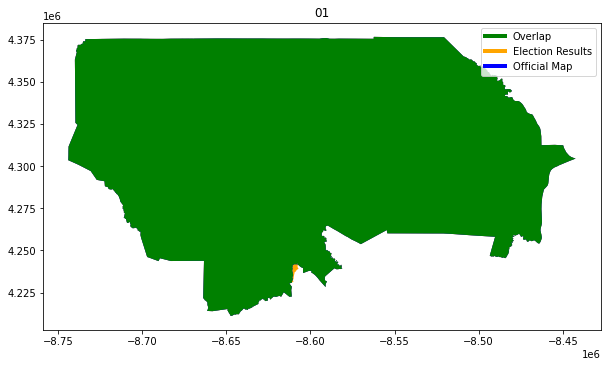

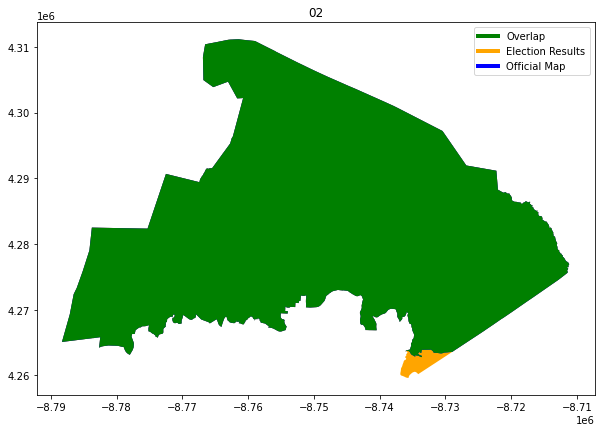

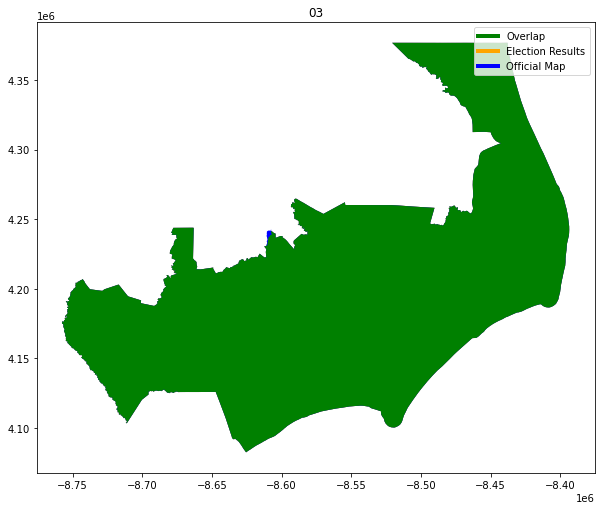

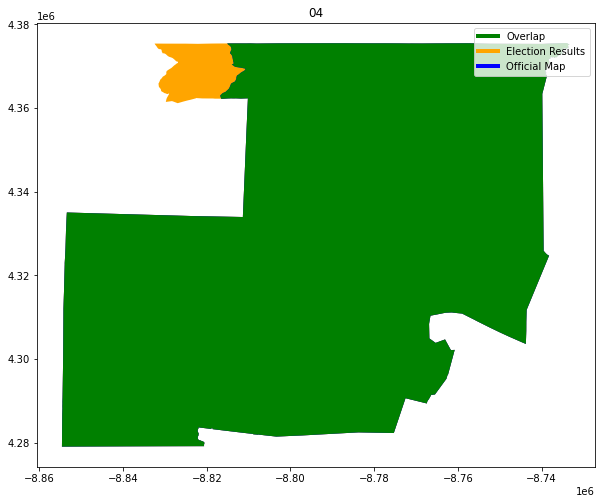

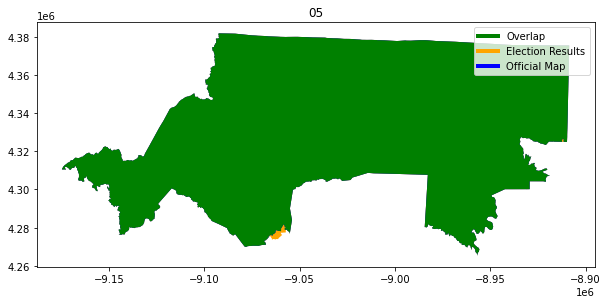

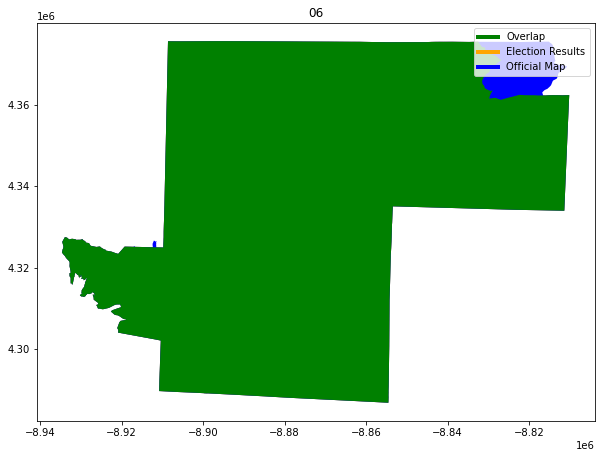

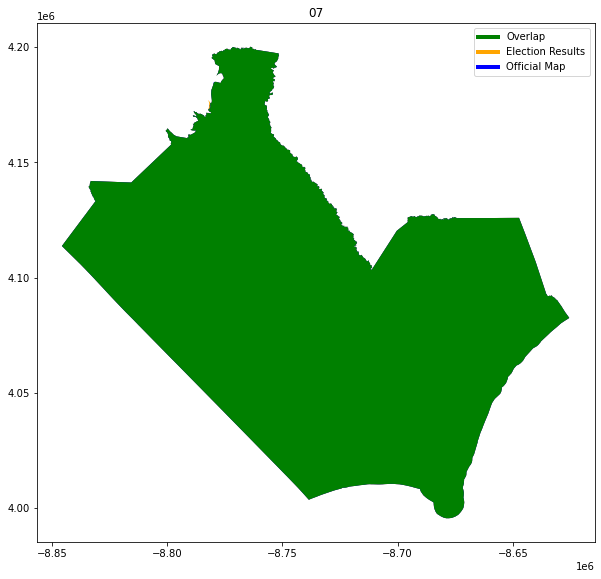

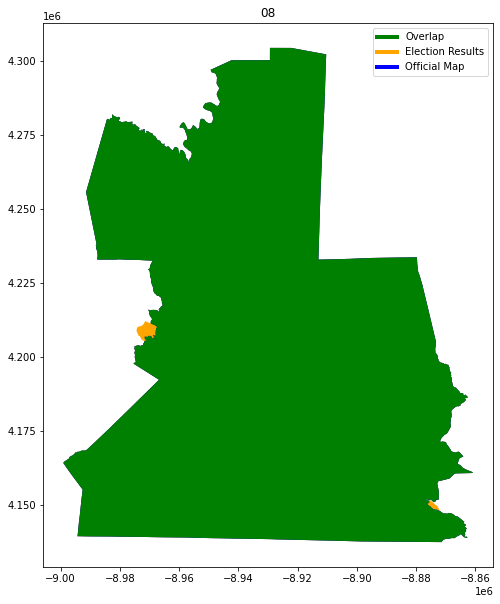

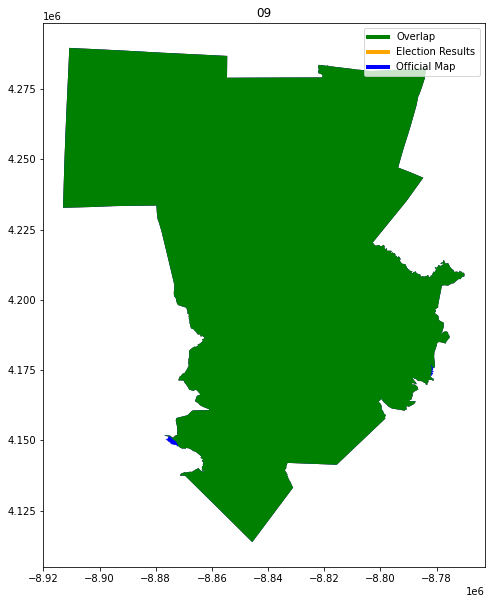

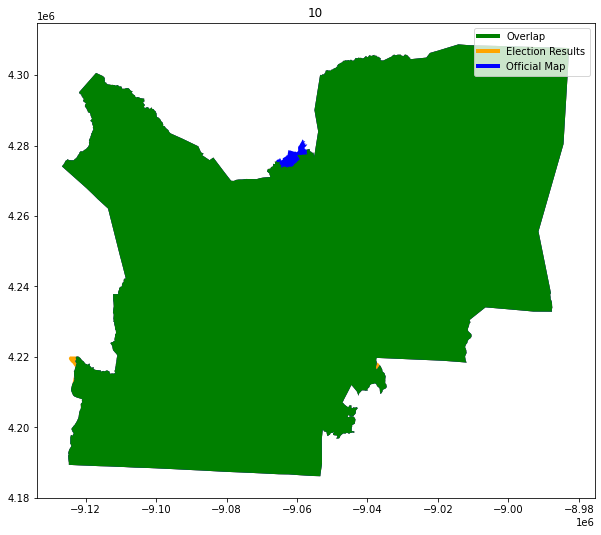

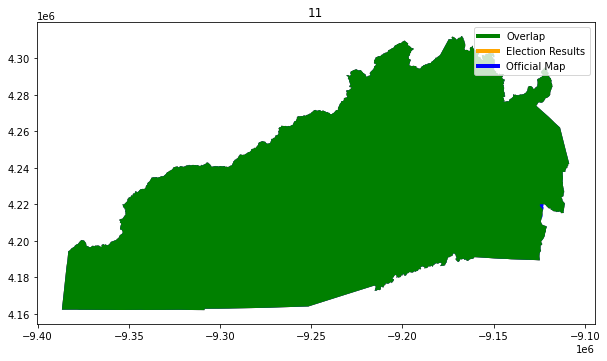

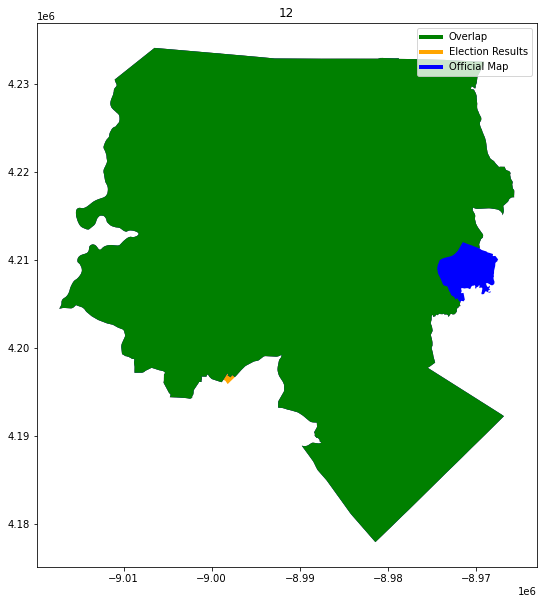

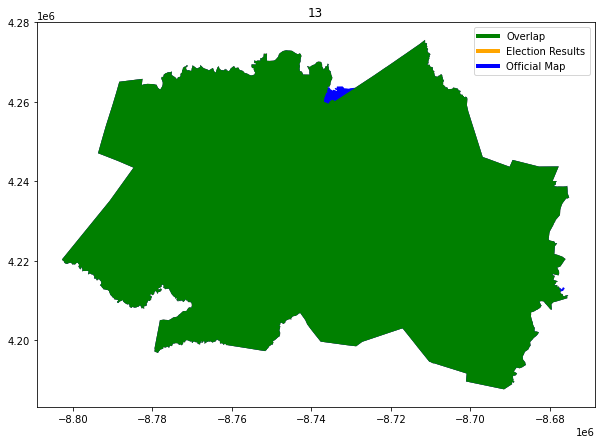

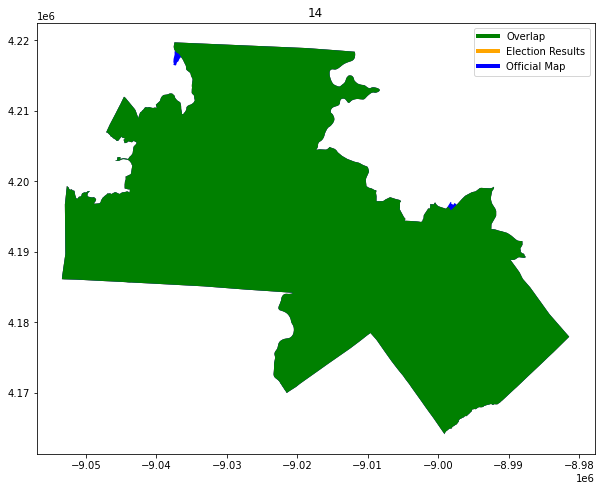

In [23]:
compare_geometries(assigned_districts, cong ,"Election Results", "Official Map", "CONG_DIST",area_threshold=.1)

Checking 14 precincts for differences of greater than 0.1 km^2

1) For 01 difference in area is 1.7408569899793234
2) For 02 difference in area is 1.6054587054511207
3) For 03 difference in area is 1.8112599071887363
4) For 04 difference in area is 21.46028335075672
5) For 05 difference in area is 2.706487210429808
6) For 06 difference in area is 21.5891327007302
7) For 07 difference in area is 0.18389043059399718
8) For 08 difference in area is 3.4514941010274014
9) For 09 difference in area is 17.043167666364834
10) For 10 difference in area is 3.137666875286565
11) For 11 difference in area is 0.43659266587851187
12) For 12 difference in area is 2.8786713184728154
13) For 13 difference in area is 17.8948511306714
14) For 14 difference in area is 0.19268608398170986

Scroll down to see plots of any differences

Of the 14 precincts:

0 precincts w/ a difference of 0 km^2
0 precincts w/ a difference between 0 and .1 km^2
3 precincts w/ a difference between .1 and .5 km^2
0 precincts w/

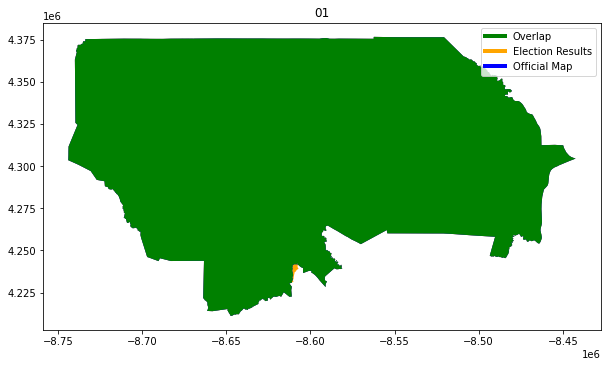

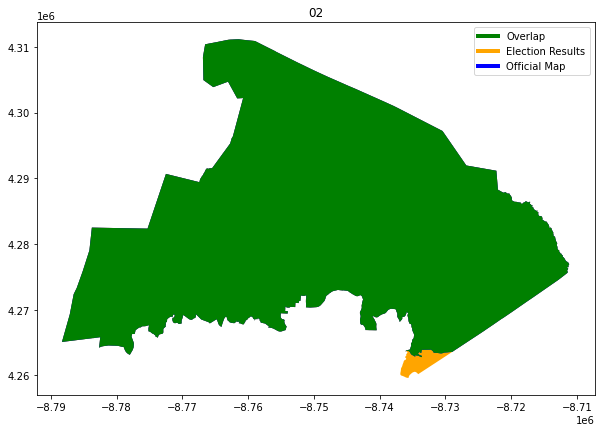

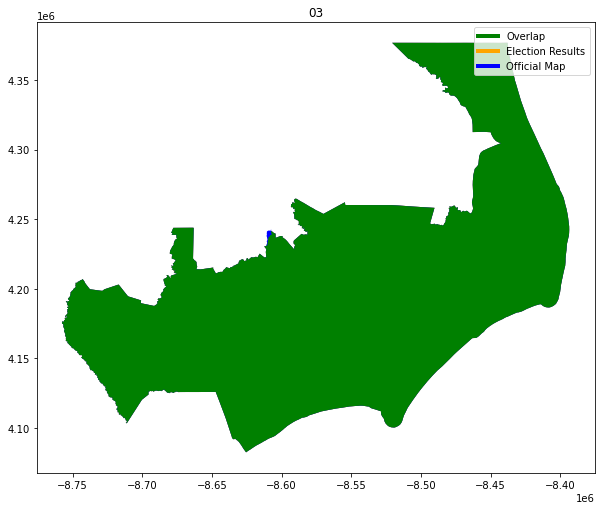

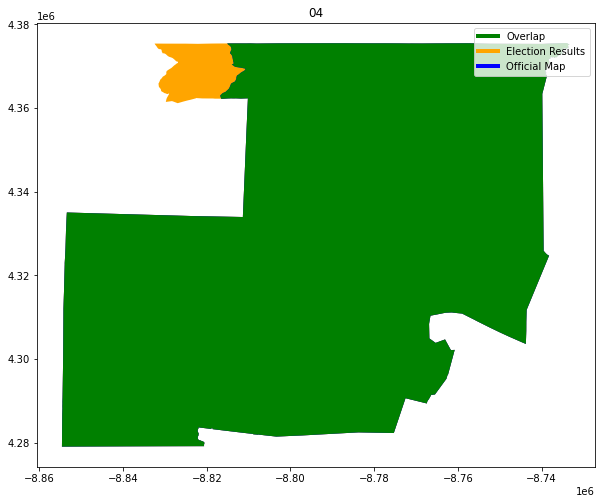

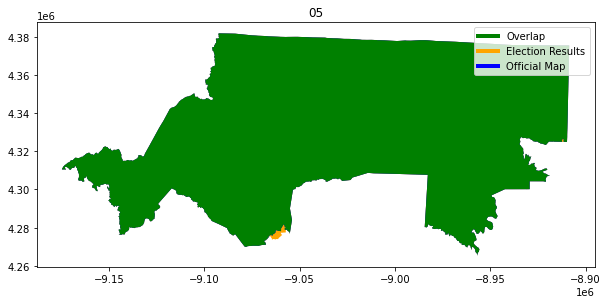

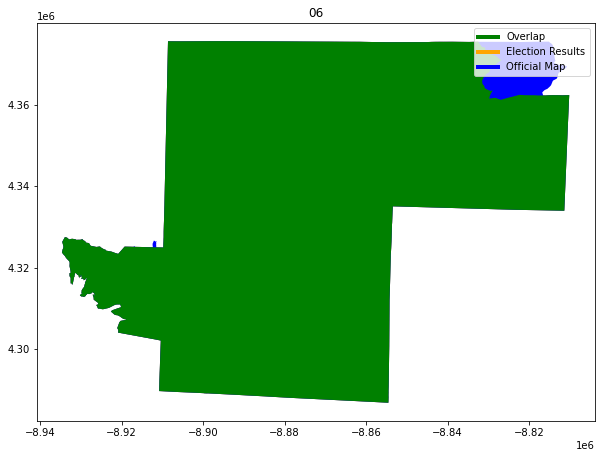

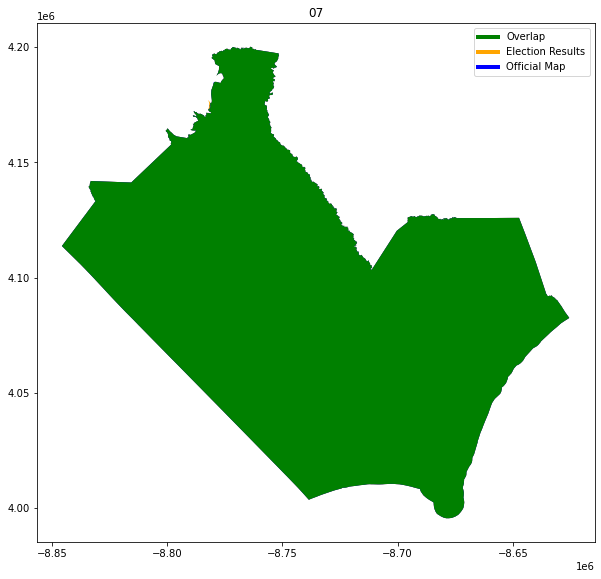

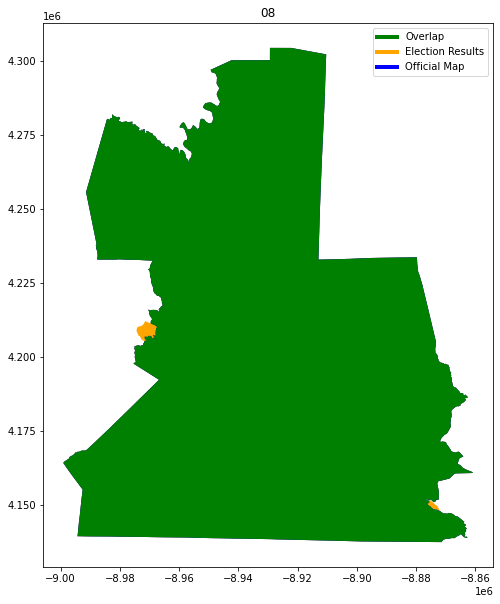

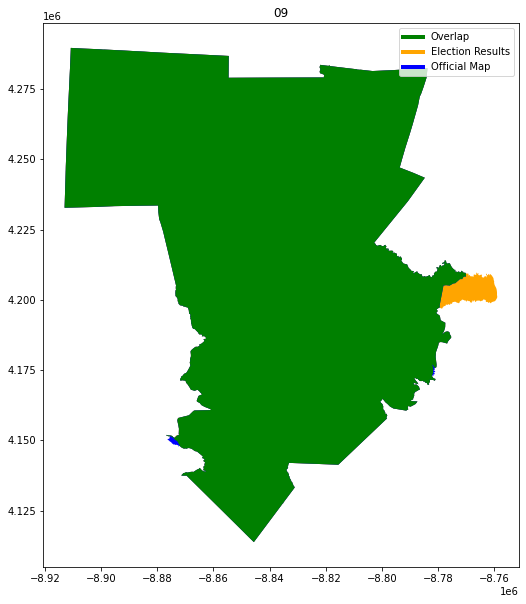

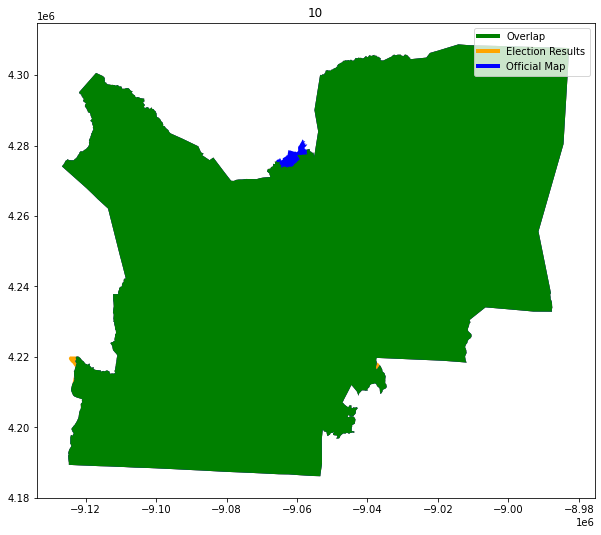

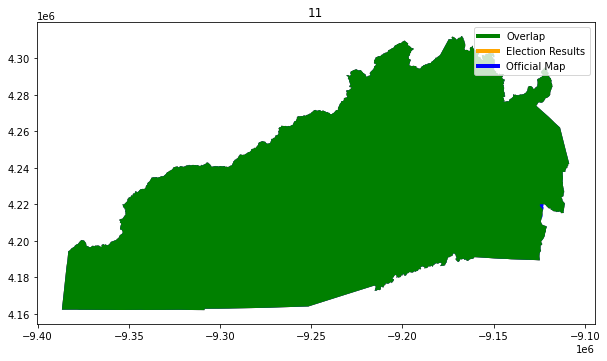

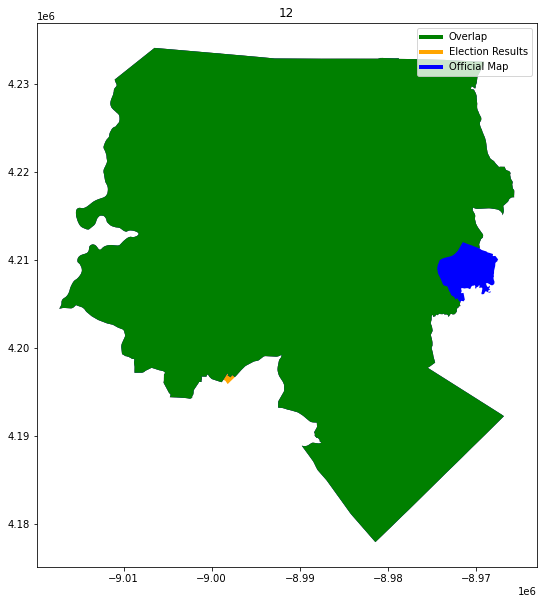

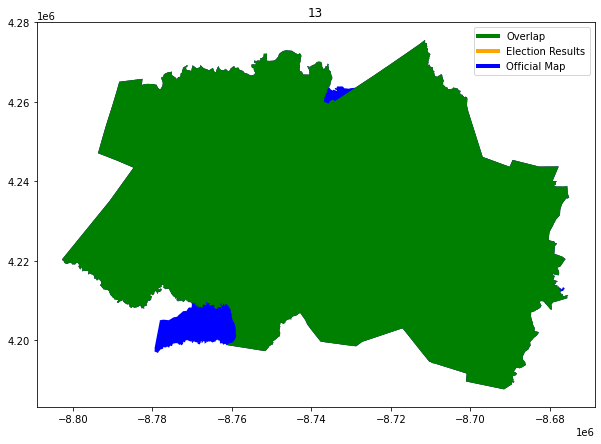

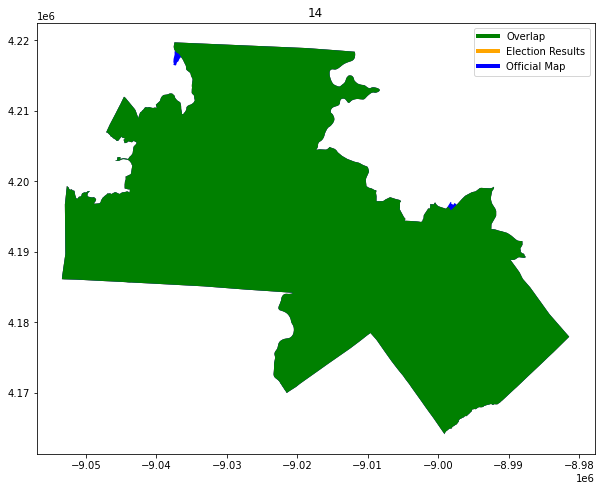

In [24]:
#Run difference check on original gdf to confirm that some splits were achieved
copy = pber_cong.copy().dissolve(["CONG_DIST"])
compare_geometries(copy, cong ,"Election Results", "Official Map", "CONG_DIST",area_threshold=.1)

## Prepare to export

In [25]:
join_attempt_1

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,CONG_DIST,GCON01DDAV,GCON01RSMI,GCON02DROS,GCON02RVIL,GCON03DGAS,GCON03RMUR,GCON04DFOU,GCON04RGEE,GCON05DPAR,GCON05RFOX,GCON06DMAN,GCON06LWAT,GCON06RCAS,GCON07DGRA,GCON07RROU,GCON08DHUF,GCON08RBIS,GCON09DCLA,GCON09RHUD,GCON10DGEN,GCON10OWRI,GCON10RMCH,GCON11DBEA,GCON11LCOA,GCON11REDW,GCON12DADA,GCON12RLEE,GCON13DNIC,GCON13RHIN,GCON14DJAC,GCON14RHAR,geometry
0,BURKE---0001,23,BURKE,0001,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,439,2,1108,0,0,0,0,0,0,0,0,0,"POLYGON ((1233595.464 737538.312, 1233589.172 ..."
1,STANLY---0003,167,STANLY,0003,08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,494,680,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1644857.853 584760.831, 1644768.728 ..."
2,BURKE---0003,23,BURKE,0003,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,134,1,498,0,0,0,0,0,0,0,0,0,"POLYGON ((1220715.101 726879.358, 1220723.026 ..."
3,STANLY---0007,167,STANLY,0007,08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,381,739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1650578.509 584607.573, 1650484.945 ..."
4,STANLY---0008,167,STANLY,0008,08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,479,89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1646657.855 579294.538, 1646677.799 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2652,HAYWOOD---WAYNESVILLE WEST,87,HAYWOOD,WAYNESVILLE WEST,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,380,17,517,0,0,0,0,0,0,"POLYGON ((808739.181 660103.212, 808721.741 66..."
2653,CASWELL---YANCEYVILLE,33,CASWELL,YANCEYVILLE,06,0,0,0,0,0,0,0,0,0,0,502,12,471,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((1922279.006 944060.291, 1922142.357 ..."
2654,HARNETT---PR20-(CONG-07),85,HARNETT,PR20,07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((2045534.669 546970.906, 204545..."
2655,HARNETT---PR20-(CONG-09),85,HARNETT,PR20,09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71,77,0,0,0,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((2039555.027 545998.955, 203980..."


In [26]:
join_attempt_1.to_file("./nc_2022_gen_prec/nc_gen_22_cong_prec.shp")